In [1]:
# -*- coding: utf-8 -*-
# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, get_month_names
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.chart_kwargs as ck
import resources.sr_ut as sut

# images and display
from IPython.display import Markdown as md

# set the locale to the language desired
date_lang =  'de_DE.utf8'
language = "de"
locale.setlocale(locale.LC_ALL, date_lang)

# the date is in iso standard:
date_format = "%Y-%m-%d"
# it gets changed to german format
# german_date_format = "%d.%m.%Y"

# set some parameters:
start_date = "2020-03-01"
end_date ="2021-05-31"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100 m"
p_unit_label = "p/100 m"

# charting and colors
sns.set_style("whitegrid")
table_row = "saddlebrown"
# colors for gradients
cmap2 = ck.cmap2
colors_palette = ck.colors_palette
a_color = "saddlebrown"

## !! Begin Note book variables !!

# Changing these variables produces different reports
# Call the map image for the area of interest
bassin_map = "resources/maps/bielersee_scaled.jpeg"

# the label for the aggregation of all data in the region
top = "Alle Erhebungsgebiete"

# define the feature level and components
# the feature of interest is the Aare (aare) at the river basin (river_bassin) level.
# the label for charting is called 'name'
this_feature = {'slug':'bielersee', 'name':"Bielersee", 'level':'water_name_slug'}

# the lake is in this survey area
this_bassin = "aare"
# label for survey area
bassin_label = "Aare-Erhebungsgebiet"

# these are the smallest aggregated components
# choices are water_name_slug=lake or river, city or location at the scale of a river bassin 
# water body or lake maybe the most appropriate
this_level = 'city'

# identify the lakes of interest for the survey area
lakes_of_interest = ["bielersee"]    

# !! End note book variables !!

# column names for the dimensions table output
dims_table_columns={
    "samples":"Erhebungen",
    "quantity":"Objekte",
    "total_w":"Gesamt-kg",
    "mac_plast_w":"kg Plastik",
    "area":"m²",
    "length":"Meter"
}

# Survey location details (GPS, city, land use)
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# Survey dimensions and weights
dfDims = pd.read_csv("resources/corrected_dims.csv")



# Object code definitions, labels and material type
# dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
# # set the index of code data to code
# dfCodes.set_index("code", inplace=True)
# # the surveyor designated the object as aluminum instead of metal
# dfCodes.loc["G708", "material"] = "Metal"

# # language specific
# # importing german code descriptions
# de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
# de_codes.set_index("code", inplace=True)

# for x in dfCodes.index:
#     dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]
# # there are long code descriptions that may need to be shortened for display
# codes_to_change = [
#     ["G704", "description", "Seilbahnbürste"],
#     ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
#     ["G30", "description", "Snack-Verpackungen"],
#     ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
#     ["G87", "description", "Abdeckklebeband / Verpackungsklebeband"],
#     ["G3","description","Einkaufstaschen, Shoppingtaschen"],
#     ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
#     ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
#     ["G211", "description", "Sonstiges medizinisches Material"],
#     ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
#     ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"],
#     ["G178", "description", "Kronkorken, Lasche von Dose/Ausfreisslachen"],
#     ["G74", "description", "Schaumstoffverpackungen/Isolierung"],
#     ["G941", "description", "Verpackungsfolien, nicht für Lebensmittel"]
# ]

# # apply changes
# for x in codes_to_change:
#     dfCodes = sut.shorten_the_value(x, dfCodes)
    
# # translate the material column
# dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# # make a map to the code descriptions
# code_description_map = dfCodes.description

# # make a map to the code materials
# code_material_map = dfCodes.material



In [2]:
def thereIsData(data=False, atype=(pd.DataFrame, )):
    # checkes that the provided data is a certain type
    if isinstance(data, atype):
        return data
    else:
        raise TypeError(f"There is no data or it is not the right type: is_instance({data}, {atype}).")

def loadData(filename):
    # loads data from a .csv
    filename = thereIsData(data=filename, atype=(str,))
    
    try:
        a = pd.read_csv(filename)        
    except OSError:
        print("The file could not be read, is this the right file extension?")
        raise
    return a

def changeColumnNames(data, columns={}):
    # changes the column names of a data frame
    data = thereIsData(data=data, atype=(pd.DataFrame, ))
    cols = thereIsData(data=columns, atype=(dict, ))
    
    try:
        a = data.rename(columns=columns)
    except ValueError:
        print("The columns did not go with the data")
        raise
    return a

def makeEventIdColumn(data, feature_level, these_features=[], date_range=(), index_name="loc_date", index_prefix="location", index_suffix="date", **kwargs):
    # Combines the location and date column into one str: "slug-date"
    # makes it possible ot group records by event
    # converts string dates to timestamps and localizes to UTC
    data = thereIsData(data=data, atype=(pd.DataFrame, ))
    feature_level = thereIsData(data=feature_level, atype=(str, ))
    these_features = thereIsData(data=these_features, atype=(list, np.ndarray))
    
    
    try:
        sliced_data = data[data[feature_level].isin(these_features)].copy()    
        sliced_data[index_name] = list(zip(sliced_data[index_prefix].values, sliced_data[index_suffix].values))
        sliced_data["date"] = pd.to_datetime(sliced_data["date"], format=date_format).dt.tz_localize('UTC')
    except RuntimeError:
        print("The pandas implementation did not function")
        raise
        
    temporal_mask = (sliced_data["date"] >= date_range[0])&(sliced_data["date"] <= date_range[1])
    
    return sliced_data[temporal_mask].copy()
    
def featureData(filename, feature_level, date_range=[], these_features=[], columns=False, language="en"):
    # makes the feature data to be explored    
    data = loadData(filename)
    
    if columns != False:
        data = changeColumnNames(data, columns=columns)
    if language == "de":
        data["groupname"] = data["groupname"].map(lambda x: sut.group_names_de[x])
    a = makeEventIdColumn(data, feature_level, date_range=date_range, these_features=these_features)
    
    return a, data

def convert_case(str_camelcase):
    # This function takes in a string in camelCase and converts it to snake_case
    str_camelcase = thereIsData(data=str_camelcase, atype=(str, ))
    str_snake_case = ""
    for ele in list(str_camelcase):
        if ele.islower():
            str_snake_case = str_snake_case + ele
        else:
            str_snake_case = str_snake_case + "_" + ele.lower()
    return str_snake_case


def checkInitiateAttribute(data=False, check=False, atype=(list, np.ndarray), a_method=None, **kwargs):
    # check the data type of the requested element against the required data type
    # if check the data is returned, else <a_method> will be applied to <data>
    # and checked again.    
    if isinstance(check, atype):
        return check
    else:
        try:
            new_data = a_method(data)
            check_again = checkInitiateAttribute(check=new_data, data=new_data, atype=atype, a_method=a_method, **kwargs)
            return check_again
            
        except ValueError:
            print("neither the data nor the method worked")
            raise
            
def uniqueValues(data):
    # method to pass pd.series.unique as a variable
    return data.location.unique()

def dateToYearAndMonth(python_date_object, fmat='wide', lang=""):
    a_date = thereIsData(data=python_date_object, atype=(datetime, ))
    amonth = a_date.month
    a_year = a_date.year
    amonth_foreign = get_month_names(fmat, locale=lang)[amonth]
    
    return f'{amonth_foreign} {a_year}'
    
def thousandsSeparator(aninteger, lang):
    
    astring = "{:,}".format(aninteger)
    
    if lang == "de":
        astring = astring.replace(",", " ")        
        
    return astring

def createSummaryTableIndex(unit_label, language="en"):
    """Assigns the current units to the keys and creates
    custom key values based on language selection.
    
    :param unit_label: The current value of unit label
    :param lang: the two letter abbreviation for the current language
    :return: the pd.describe dict with custom labels
    """
    
    if language == "en":
        new_data = {"count":"# samples",
             "mean":f"average {unit_label}",
             "std":"standard deviation", 
             "min":f"min {unit_label}",
             "max":f"max {unit_label}",
             "25%":"25%",
             "50%":"50%", 
             "75%":"75%",
             "total objects":"total objects",
             "# locations":"# locations",
         }
    elif language == "de":
        new_data = {"count":"Anzahl Proben",
                "mean":f"Durchschnitt {unit_label}",
                "std":"Standardfehler", 
                "min":f"min {unit_label}",
                "max": f"max {unit_label}",
                "25%":"25%",
                "50%":"50%", 
                "75%":"75%",
                "total objects":"Abfallobjekte total",
                "# locations":"Anzahl der Standorte",
               }
    else:
        print(f"ERROR {lang} is not an option")
        new_data = {}              
    
    return new_data



def changeSeriesIndexLabels(a_series: pd.Series=None, change_names: {}=None):
    """A convenience funtion to change the index labels of a series x.
    Change_names is keyed to the series index.
    
    :param x: A pandas series
    :param change_names: A dictionary that has keys = x.index and
        values = new x.index label
    :return: The series with the new labels
    """
    
    new_dict = {}
    for param in a_series.index:
        new_dict.update({change_names[param]:a_series[param]})
    return pd.Series(new_dict)





agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}



codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband / Verpackungsklebeband"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"],
    ["G178", "description", "Kronkorken, Lasche von Dose/Ausfreisslachen"],
    ["G74", "description", "Schaumstoffverpackungen/Isolierung"],
    ["G941", "description", "Verpackungsfolien, nicht für Lebensmittel"]
]




class Codes:
    de_codes_to_change = codes_to_change
    de_code_description = loadData("resources/codes_german_Version_1.csv")
    materials_ge = {"Metal":"Metall", 
          "Chemicals":"Chemikalien",
          "Paper":"Papier",
          "Glass":"Glas",
          "Rubber":"Gummi",
          "Wood":"Holz",
          "Cloth":"Stoff",
          "Unidentified":"Unbekannt",
          "Undefined":"Unbestimmt",
          "Plastic":"Plastik",
          "Alu":"Alu",
         }
        
    def __init__(self, code_data: pd.DataFrame=None, language: 'str' = 'en'):        
        print("Codes init called")
        self.code_data = code_data
        self.language = language
        self.dfCodes = False
        self.dMap = False
        self.mMap = False
        
        
        
    def adjustForLanguage(self):
        if self.dfCodes:
            print("The code data was previously established. Use Codes.dfCodes to for the dataframe")
            return self.dfCodes
                    
                
        if self.language == 'de':
            print('this is german')
            
            dmap = self.de_code_description[['code', 'german']].set_index('code')
            
            # translated = [x for x in dfCodes.index if x in self.de_code_description.index]
            new_code_data = self.code_data.copy()
            
            for code in new_code_data.index:
                new_code_data.loc[code, "description"] = dmap.loc[code, "german"]                
            for code_def in codes_to_change:
                new_code_data.loc[code_def[0], code_def[1]] = code_def[2]
            
            # print(self.code_data.head())
            new_code_data["material"] = new_code_data.material.map(lambda x: self.materials_ge[x])
            
        print('making material and description map')
            
        self.dfCodes = new_code_data
        self.mMap = new_code_data.material
        self.dMap = new_code_data.description

            

class FeatureData(Codes):    
    
    
    def __init__(self, filename: str="", feature_name: str="", feature_level: str="",
                 these_features: []=[], component: str="",  date_range: []=None, fail_rate: int=0, columns: list=False,
                 language: str="en", unit_label: str="pcs/100m", code_data: pd.DataFrame=None,):
        super().__init__(code_data, language)
        self.filename = filename
        self.feature = feature_name
        self.feature_level= feature_level
        self.these_features = these_features
        self.feature_component = component
        self.columns =columns
        self.fail_rate=fail_rate
        self.date_range = date_range
        self.unit_label = unit_label
        self.feature_data = None
        self.code_summary = None
        self.material_summary = None        
        self.most_common = None
        self.sample_totals = None
        self.sample_summary = None                
        
    
    def makeFeatureData(self):
        
        if isinstance(self.feature_data, pd.DataFrame):
            print("The feature data has already been generated, it can be accessed through FeatureData.feature_data")
            return self.feature_data
        print('making feature data')
        print('date_range', self.date_range)
        
        fd_kwargs = {
            "these_features":self.these_features,
            "columns":self.columns,
            "language":self.language,
            'date_range':self.date_range
        }
        fd, _ = featureData(self.filename, self.feature_level, **fd_kwargs)        
        self.feature_data = fd
        
    def columnOperation(self, columns_operations: [()]=False):
        return {x[0]:x[1] for x in column_operations}
        
    def locationSampleTotals(self, column_operations: [()]=None, columns: []=False):
        
        if isinstance(self.sample_totals, pd.DataFrame):
            print("the sample totals have already been generated, access through FeatureData.sample_totals")
            return self.sample_totals
        
        print('sample totals')
        
        if not columns:
            columns = ["loc_date","location",self.feature_component,"date"]
        if column_operations:
            column_operation = self.columnOperation(column_operations)
        else:
            column_operation = {self.unit_label:"sum", "quantity":"sum"}
            
        if not isinstance(self.feature_data, pd.DataFrame):
            self.makeFeatureData()
        
        self.sample_totals = self.feature_data.groupby(columns, as_index=False).agg(column_operation)
    
    def codeSummary(self, column_operations=None):
        
        if isinstance(self.code_summary, pd.DataFrame):
            print("code summary has already been generated, it can be accessed through FeatureData.code_summary")
            return self.code_summary       
        
        if column_operations:
            column_operation = self.columnOperation(column_operations)
        
        else:
            column_operation = {self.unit_label:"median", "quantity":"sum"}
        
        # apply the column operations
        code_totals = self.feature_data.groupby('code', as_index=False).agg(column_operation)    
        
        # percent of total
        code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)

        # fail and fail-rate
        code_totals["fail"] = code_totals.code.map(lambda x: self.feature_data[(self.feature_data.code == x) & (self.feature_data.quantity > 0)].loc_date.nunique())
        code_totals["fail rate"] = ((code_totals.fail/self.feature_data.loc_date.nunique())*100).astype("int")
        
        # the code data comes from the feature data (survey results)
        # Add the description of the code and the material
        code_totals.set_index("code",inplace=True)
        code_totals["item"] = code_totals.index.map(lambda x: self.dMap[x])
        code_totals["material"] = code_totals.index.map(lambda x: self.mMap[x])
        
        self.code_summary = code_totals
        
    def materialSummary(self):
        
        if isinstance(self.material_summary, pd.DataFrame):
            print('the material summary has already been generated, it can be accessed through FeatureData.material_summary')
            return self.material_summary
        
        if not isinstance(self.code_summary, pd.DataFrame):
            print("making the code summary first")
            self.codeSummary()
        
        print("making material summary")
        a = self.code_summary.groupby("material", as_index=False).quantity.sum()
        a["% of total"] = a['quantity']/a['quantity'].sum()
        b = a.sort_values(by="quantity", ascending=False)
        
        self.material_summary = b
        
    def mostCommon(self, fail_rate: int=False, limit: int=10):
        
        if isinstance(self.most_common, pd.DataFrame):
            print("the most common codes table has already been genrated, it can be accessed through FeatureData.most_common")
            return self.most_common
        
        if not isinstance(self.code_summary, pd.DataFrame):
            print("making a code summary first")
            self.codeSummary()
        if not fail_rate:
            print("getting the fail rate")
            fail_rate = self.fail_rate
            
        print('making most common codes table')            
        
        # the top ten by quantity
        most_abundant = self.code_summary.sort_values(by="quantity", ascending=False)[:limit]

        # the most common
        most_common = self.code_summary[self.code_summary["fail rate"] >= fail_rate].sort_values(by="quantity", ascending=False)

        # merge with most_common and drop duplicates
        # it is possible (likely) that a code will be abundant and common
        m_common = pd.concat([most_abundant, most_common]).drop_duplicates()        
        
        self.most_common = m_common
        
    def makeDailyTotalSummary(self):
        print(self)        
    
        if isinstance(self.sample_summary, pd.Series):
            print("the summary has already been generated, access through FeatureData.sample_summary")
            return self.sample_summary
        print("making daily total summary")
        if not isinstance(self.sample_totals, pd.DataFrame):
            print("generating the sample totals first")
            self.locationSampleTotals()

        # the summary of the dependent variable
        a = self.sample_totals[self.unit_label].describe().round(2)

        # assign appropriate language to index names
        # retrieve the appropriate index names based on language
        table_index = createSummaryTableIndex(self.unit_label, language=self.language)
        
        # assign the new index
        summary_table = changeSeriesIndexLabels(a, table_index)

        self.sample_summary = summary_table
        
    def __str__(self):
        
        return f"{self.feature}, {self.feature_level}, {self.these_features}, {self.feature_component}"
    

class Components(FeatureData, Codes):
    
    def __init__(self, *args, **kwargs):
        super().__init__(**kwargs)
    
    def componentMostCommonPcsM(self, columns: list=None, column_operations: list=None, **kwargs):
        codes = self.most_common.index
        if not isinstance(columns, list):
            columns = [self.feature_component, "loc_date","code"]
        if isinstance(column_operations, list):
            column_operation = self.columnOperation(column_operations)        
        else:
            column_operation = {self.unit_label:"sum", "quantity":"sum"}
            
        a = self.feature_data[self.feature_data.code.isin(codes)].groupby(columns, as_index=False).agg(column_operation)
        a = a.groupby([self.feature_component, "code"], as_index=False)[self.unit_label].median()
        
        # map the desctiption to the code
        a["item"] = a.code.map(lambda x: self.dMap.loc[x])
        
        return a
    
    def componentCodeGroupResults(self, columns: []=None, column_operations: []=None, **kwargs):
        
        """Produces two arrays of the aggregated survey results by codegroup for each feature component. Rows are the 
        feature component, columns are the codegroup. One array is % of total the other is median pcs/m.
        """    
        if not isinstance(columns, list):
            # the results are aggregated at the sample level first
            columns = ["loc_date","groupname"]        
        if isinstance(column_operations, list):
            column_operation = self.columnOperation(column_operations)        
        else:
            column_operation = {unit_label:"sum", "quantity":"sum"}

        results = self.feature_data.groupby([self.feature_component,*columns], as_index=False).agg(column_operation)

        # the total amount per component, used for % of total array
        cg_tq = results.groupby(self.feature_component).quantity.sum()
        
        print(cg_tq.head())

        # the median per survey per group and the total quantity
        agg_this = {unit_label:"median", "quantity":"sum"}
        results = results.groupby([self.feature_component, "groupname"], as_index=False).agg(agg_this)
        results["f_total"] = results[self.feature_component].map(lambda x: cg_tq.loc[x])
        results["pt"] = (results.quantity/results.f_total).round(2)

        return results
    

class Beaches:
    """The dimendsional and geo data for each survey location"""
    def __init__(self, dfBeaches: pd.DataFrame=None):
        self.df_beaches = dfBeaches
    

class AdministrativeSummary(Beaches):
       
    col_nunique_qty=["location", "loc_date", "city"]
    col_sum_qty = ["quantity"]
    col_population = ["city", "population"]
    col_sum_pop = ["population"]
    col_nunique_city = ["city"]
    locations_of_interest = None
    lakes_of_interest = None
    rivers_of_interest = None
    
    def __init__(self, data: pd.DataFrame=None, dims_data: pd.DataFrame=None, feature_component: str=None, label: str=None, date_range: ()=None, **kwargs):
        super().__init__(**kwargs)
        
        self.feature_data = data
        self.label = label
        self.dims_data = dims_data
        self.feature_component = feature_component
        self.date_range=date_range
        self.locations_of_interest = None
            
        
    def locationsOfInterest(self, **kwargs):        
        data = thereIsData(self.feature_data, pd.DataFrame)
        locations = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues, **kwargs)
                
        self.locations_of_interest = locations
    
    def resultsObject(self, col_nunique=None, col_sum=None, **kwargs):
        data = thereIsData(self.feature_data, pd.DataFrame)
        
        if not col_nunique:
            col_nunique=self.col_nunique_qty
        if not col_sum:
            col_sum=self.col_sum_qty
            
        t = sut.make_table_values(data, col_nunique=col_nunique, col_sum=col_sum)
        
        return t
    
    def populationKeys(self):
        data = thereIsData(self.feature_data, pd.DataFrame)
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
        try:
            popmap = self.df_beaches.loc[locs][self.col_population].drop_duplicates()
        except TypeError as e:
            print("that did not work")
        
        return popmap
    
    def lakesOfInterest(self):
        data = thereIsData(self.feature_data, pd.DataFrame)
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
               
        if not isinstance(self.lakes_of_interest, list):
            mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "l")
            d = self.df_beaches.loc[mask]["water_name"].unique()
            self.lakes_of_interest = d
            return d
        else:
            return self.lakes_of_interest
        
    def riversOfInterest(self):
        data = thereIsData(self.feature_data, pd.DataFrame)        
        locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)      
        
        if not isinstance(self.rivers_of_interest, list):
            mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "r")
            d = self.df_beaches.loc[mask]["water_name"].unique()
            self.rivers_of_interest = d
            return d
        else:
            return self.rivers_of_interest
        
    def summaryObject(self, **kwargs):
        
        t = self.resultsObject()
        pop_values = sut.make_table_values(self.populationKeys(), col_nunique=self.col_nunique_city, col_sum=self.col_sum_pop)
        if not isinstance(self.locations_of_interest, (list, np.ndarray)):
            self.locationsOfInterest()
        t["locations_of_interest"] = self.locations_of_interest
       
        t.update(pop_values)
        
        return t
    
    def dimensionalSummary(self):
        
        # map location to component name
        try:
            component_map = self.df_beaches[self.feature_component]
        except AttributeError:
            print("The beaches data frame is missing or the feature component is not valid")
            raise        
        # slice data to feature data
        try:
            location_mask = (self.dims_data.location.isin(self.locations_of_interest))
        except AttributeError:
            print("Unable to make location mask, either the dimensional data is missing or the locations of interest do not correspond")
            raise
        
        try:
            temporal_mask = (self.dims_data["date"] >= self.date_range[0])&(self.dims_data["date"] <= self.date_range[1])
        except AttributeError:
            print("Unable to make temporal mask, either the dimensional data is missing or the of the date range variable is incorrect")
            raise
            
        try:
            dims_table = self.dims_data[location_mask & temporal_mask].copy()
        except AttributeError:
            print("Unable to make dimensional data table, there is a problem with the either the data or location and temporal masks")
            raise
            
        
        # unique id for each survey
        dims_table["loc_date"] = list(zip(dims_table.location.values, dims_table["date"].values))
        
        # values of interest
        agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

        dims_table[self.feature_component] = dims_table.location.map(lambda x: component_map.loc[x])
        dims_table = dims_table.groupby([self.feature_component]).agg(agg_dims)
                        
        # map the qauntity to the dimensional data
        q_map = self.feature_data.groupby(self.feature_component).quantity.sum()

        # collect the number of samples from the survey total data:
        for name in dims_table.index:
            dims_table.loc[name, "samples"] = self.feature_data[self.feature_data[self.feature_component] == name].loc_date.nunique()
            dims_table.loc[name, "quantity"] = q_map[name]

        # get the sum of all survey areas
        dims_table.loc[self.label]= dims_table.sum(numeric_only=True, axis=0)

        return dims_table
    
dxCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dxCodes.set_index("code", inplace=True)
dxCodes.loc["G708", "material"] = "Metal"
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}
fail_rate = 50
fd_kwargs ={
    "filename": "resources/checked_sdata_eos_2020_21.csv",
    "feature_name": this_feature['name'], 
    "feature_level": this_feature['level'], 
    "these_features": lakes_of_interest, 
    "component": this_level, 
    "columns": columns, 
    "language": 'de', 
    "unit_label": unit_label, 
    "fail_rate": fail_rate,
    "code_data":dxCodes,
    "date_range": start_end
    
    
}



fdx = Components(**fd_kwargs)
fdx.makeFeatureData()
fdx.adjustForLanguage()
    
# the survey data
filename = "resources/checked_sdata_eos_2020_21.csv"
columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}
_, a_data = featureData(filename, this_feature["level"], date_range=start_end, these_features=[this_feature["slug"]], columns=columns, language="de")

fd = fdx.feature_data
# collects the summarized values for all the data in the region
summary_data = AdministrativeSummary(data=fd, dims_data=dfDims, label=this_feature["name"], feature_component=this_level, date_range=start_end, **{"dfBeaches":dfBeaches})

Codes init called
making feature data
date_range ['2020-03-01', '2021-05-31']
this is german
making material and description map


(bielersee_de)=
# Bielersee

In [3]:
class Caption:
    
    position=''
    figure_number=0
    captions=[]
    start_caption = ""
    end_caption = '*'
    
    def buildCaption(self):
        start_caption = f'*__{self.position}:__'
        new_string=''
        for line in self.captions:
            new_string += line
        end_caption = self.end_caption
        
        return f'{start_caption} {new_string}{end_caption}'
            
map_caption = Caption()
map_caption.position = "Unten"
map_caption.captions = [
    "Karte des Erhebungsgebiets März 2020 bis Mai 2021. ",
    "Der Durchmesser der Punktsymbole entspricht dem Median der",
    "Abfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort."
]
md(map_caption.buildCaption())

*__Unten:__ Karte des Erhebungsgebiets März 2020 bis Mai 2021. Der Durchmesser der Punktsymbole entspricht dem Median derAbfallobjekte pro 100 Meter (p/100 m) am jeweiligen Erhebungsort.*

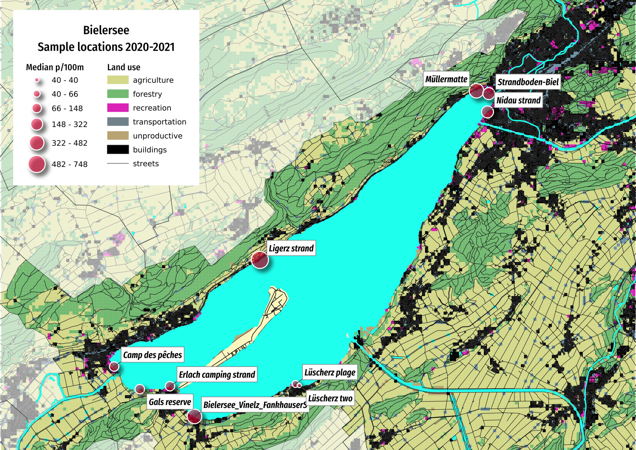

In [4]:
sut.display_image_ipython(bassin_map, thumb=(800,450))

## Erhebungsorte

In [5]:
# def thereIsData(data=False, atype=(pd.DataFrame, )):
#     # checkes that the provided data is a certain type
#     if isinstance(data, atype):
#         return data
#     else:
#         raise TypeError(f"There is no data or it is not the right type: is_instance({data}, {atype}).")

# def loadData(filename):
#     # loads data from a .csv
#     filename = thereIsData(data=filename, atype=(str,))
    
#     try:
#         a = pd.read_csv(filename)        
#     except OSError:
#         print("The file could not be read, is this the right file extension?")
#         raise
#     return a

# def changeColumnNames(data, columns={}):
#     # changes the column names of a data frame
#     data = thereIsData(data=data, atype=(pd.DataFrame, ))
#     cols = thereIsData(data=columns, atype=(dict, ))
    
#     try:
#         a = data.rename(columns=columns)
#     except ValueError:
#         print("The columns did not go with the data")
#         raise
#     return a

# def makeEventIdColumn(data, feature_level, these_features=[], date_range=(), index_name="loc_date", index_prefix="location", index_suffix="date", **kwargs):
#     # Combines the location and date column into one str: "slug-date"
#     # makes it possible ot group records by event
#     # converts string dates to timestamps and localizes to UTC
#     data = thereIsData(data=data, atype=(pd.DataFrame, ))
#     feature_level = thereIsData(data=feature_level, atype=(str, ))
#     these_features = thereIsData(data=these_features, atype=(list, np.ndarray))
    
    
#     try:
#         sliced_data = data[data[feature_level].isin(these_features)].copy()    
#         sliced_data[index_name] = list(zip(sliced_data[index_prefix].values, sliced_data[index_suffix].values))
#         sliced_data["date"] = pd.to_datetime(sliced_data["date"], format=date_format).dt.tz_localize('UTC')
#     except RuntimeError:
#         print("The pandas implementation did not function")
#         raise
        
#     temporal_mask = (sliced_data["date"] >= date_range[0])&(sliced_data["date"] <= date_range[1])
    
#     return sliced_data[temporal_mask].copy()
    
# def featureData(filename, feature_level, date_range=[], these_features=[], columns=False, language="en"):
#     # makes the feature data to be explored    
#     data = loadData(filename)
    
#     if columns != False:
#         data = changeColumnNames(data, columns=columns)
#     if language == "de":
#         data["groupname"] = data["groupname"].map(lambda x: sut.group_names_de[x])
#     a = makeEventIdColumn(data, feature_level, date_range=date_range, these_features=these_features)
    
#     return a, data

# def convert_case(str_camelcase):
#     # This function takes in a string in camelCase and converts it to snake_case
#     str_camelcase = thereIsData(data=str_camelcase, atype=(str, ))
#     str_snake_case = ""
#     for ele in list(str_camelcase):
#         if ele.islower():
#             str_snake_case = str_snake_case + ele
#         else:
#             str_snake_case = str_snake_case + "_" + ele.lower()
#     return str_snake_case


# def checkInitiateAttribute(data=False, check=False, atype=(list, np.ndarray), a_method=None, **kwargs):
#     # check the data type of the requested element against the required data type
#     # if check the data is returned, else <a_method> will be applied to <data>
#     # and checked again.    
#     if isinstance(check, atype):
#         return check
#     else:
#         try:
#             new_data = a_method(data)
#             check_again = checkInitiateAttribute(check=new_data, data=new_data, atype=atype, a_method=a_method, **kwargs)
#             return check_again
            
#         except ValueError:
#             print("neither the data nor the method worked")
#             raise
            
# def uniqueValues(data):
#     # method to pass pd.series.unique as a variable
#     return data.location.unique()

# def dateToYearAndMonth(python_date_object, fmat='wide', lang=""):
#     a_date = thereIsData(data=python_date_object, atype=(datetime, ))
#     amonth = a_date.month
#     a_year = a_date.year
#     amonth_foreign = get_month_names(fmat, locale=lang)[amonth]
    
#     return f'{amonth_foreign} {a_year}'
    
# def thousandsSeparator(aninteger, lang):
    
#     astring = "{:,}".format(aninteger)
    
#     if lang == "de":
#         astring = astring.replace(",", " ")        
        
#     return astring

# def createSummaryTableIndex(unit_label, language="en"):
#     """Assigns the current units to the keys and creates
#     custom key values based on language selection.
    
#     :param unit_label: The current value of unit label
#     :param lang: the two letter abbreviation for the current language
#     :return: the pd.describe dict with custom labels
#     """
    
#     if language == "en":
#         new_data = {"count":"# samples",
#              "mean":f"average {unit_label}",
#              "std":"standard deviation", 
#              "min":f"min {unit_label}",
#              "max":f"max {unit_label}",
#              "25%":"25%",
#              "50%":"50%", 
#              "75%":"75%",
#              "total objects":"total objects",
#              "# locations":"# locations",
#          }
#     elif language == "de":
#         new_data = {"count":"Anzahl Proben",
#                 "mean":f"Durchschnitt {unit_label}",
#                 "std":"Standardfehler", 
#                 "min":f"min {unit_label}",
#                 "max": f"max {unit_label}",
#                 "25%":"25%",
#                 "50%":"50%", 
#                 "75%":"75%",
#                 "total objects":"Abfallobjekte total",
#                 "# locations":"Anzahl der Standorte",
#                }
#     else:
#         print(f"ERROR {lang} is not an option")
#         new_data = {}              
    
#     return new_data



# def changeSeriesIndexLabels(a_series: pd.Series=None, change_names: {}=None):
#     """A convenience funtion to change the index labels of a series x.
#     Change_names is keyed to the series index.
    
#     :param x: A pandas series
#     :param change_names: A dictionary that has keys = x.index and
#         values = new x.index label
#     :return: The series with the new labels
#     """
    
#     new_dict = {}
#     for param in a_series.index:
#         new_dict.update({change_names[param]:a_series[param]})
#     return pd.Series(new_dict)





# agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}



# codes_to_change = [
#     ["G704", "description", "Seilbahnbürste"],
#     ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
#     ["G30", "description", "Snack-Verpackungen"],
#     ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
#     ["G87", "description", "Abdeckklebeband / Verpackungsklebeband"],
#     ["G3","description","Einkaufstaschen, Shoppingtaschen"],
#     ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
#     ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
#     ["G211", "description", "Sonstiges medizinisches Material"],
#     ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
#     ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"],
#     ["G178", "description", "Kronkorken, Lasche von Dose/Ausfreisslachen"],
#     ["G74", "description", "Schaumstoffverpackungen/Isolierung"],
#     ["G941", "description", "Verpackungsfolien, nicht für Lebensmittel"]
# ]




# class Codes:
#     de_codes_to_change = codes_to_change
#     de_code_description = loadData("resources/codes_german_Version_1.csv")
#     materials_ge = {"Metal":"Metall", 
#           "Chemicals":"Chemikalien",
#           "Paper":"Papier",
#           "Glass":"Glas",
#           "Rubber":"Gummi",
#           "Wood":"Holz",
#           "Cloth":"Stoff",
#           "Unidentified":"Unbekannt",
#           "Undefined":"Unbestimmt",
#           "Plastic":"Plastik",
#           "Alu":"Alu",
#          }
        
#     def __init__(self, code_data: pd.DataFrame=None, language: 'str' = 'en'):        
#         print("Codes init called")
#         self.code_data = code_data
#         self.language = language
#         self.dfCodes = False
#         self.dMap = False
#         self.mMap = False
        
        
        
#     def adjustForLanguage(self):
#         if self.dfCodes:
#             print("The code data was previously established. Use Codes.dfCodes to for the dataframe")
#             return self.dfCodes
                    
                
#         if self.language == 'de':
#             print('this is german')
            
#             self.de_code_description[['code', 'german']].set_index('code', inplace=True)
            
#             translated = [x for x in dfCodes.index if x in self.de_code_description.index]
#             new_code_data = self.code_data.copy()
            
#             for code in translated:                
#                 new_code_data.loc[code, "description"] = self.de_code_description.loc[code, "german"]                
#             for code_def in codes_to_change:
#                 new_code_data.loc[code_def[0], code_def[1]] = code_def[2]
            
#             # print(self.code_data.head())
#             new_code_data["material"] = new_code_data.material.map(lambda x: self.materials_ge[x])
            
#         print('making material and description map')
            
#         self.dfCodes = new_code_data
#         self.mMap = dfCodes.material
#         self.dMap = dfCodes.description

            

# class FeatureData(Codes):    
    
    
#     def __init__(self, filename: str="", feature_name: str="", feature_level: str="",
#                  these_features: []=[], component: str="",  date_range: []=None, fail_rate: int=0, columns: list=False,
#                  language: str="en", unit_label: str="pcs/100m", code_data: pd.DataFrame=None,):
#         super().__init__(code_data, language)
#         self.filename = filename
#         self.feature = feature_name
#         self.feature_level= feature_level
#         self.these_features = these_features
#         self.feature_component = component
#         self.columns =columns
#         self.fail_rate=fail_rate
#         self.date_range = date_range
#         self.unit_label = unit_label
#         self.feature_data = None
#         self.code_summary = None
#         self.material_summary = None        
#         self.most_common = None
#         self.sample_totals = None
#         self.sample_summary = None                
        
    
#     def makeFeatureData(self):
        
#         if isinstance(self.feature_data, pd.DataFrame):
#             print("The feature data has already been generated, it can be accessed through FeatureData.feature_data")
#             return self.feature_data
#         print('making feature data')
#         print('date_range', self.date_range)
        
#         fd_kwargs = {
#             "these_features":self.these_features,
#             "columns":self.columns,
#             "language":self.language,
#             'date_range':self.date_range
#         }
#         fd, _ = featureData(self.filename, self.feature_level, **fd_kwargs)        
#         self.feature_data = fd
        
#     def columnOperation(self, columns_operations: [()]=False):
#         return {x[0]:x[1] for x in column_operations}
        
#     def locationSampleTotals(self, column_operations: [()]=None, columns: []=False):
        
#         if isinstance(self.sample_totals, pd.DataFrame):
#             print("the sample totals have already been generated, access through FeatureData.sample_totals")
#             return self.sample_totals
        
#         print('sample totals')
        
#         if not columns:
#             columns = ["loc_date","location",self.feature_component,"date"]
#         if column_operations:
#             column_operation = self.columnOperation(column_operations)
#         else:
#             column_operation = {self.unit_label:"sum", "quantity":"sum"}
            
#         if not isinstance(self.feature_data, pd.DataFrame):
#             self.makeFeatureData()
        
#         self.sample_totals = self.feature_data.groupby(columns, as_index=False).agg(column_operation)
    
#     def codeSummary(self, column_operations=None):
        
#         if isinstance(self.code_summary, pd.DataFrame):
#             print("code summary has already been generated, it can be accessed through FeatureData.code_summary")
#             return self.code_summary       
        
#         if column_operations:
#             column_operation = self.columnOperation(column_operations)
        
#         else:
#             column_operation = {self.unit_label:"median", "quantity":"sum"}
        
#         # apply the column operations
#         code_totals = self.feature_data.groupby('code', as_index=False).agg(column_operation)    
        
#         # percent of total
#         code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)

#         # fail and fail-rate
#         code_totals["fail"] = code_totals.code.map(lambda x: self.feature_data[(self.feature_data.code == x) & (self.feature_data.quantity > 0)].loc_date.nunique())
#         code_totals["fail rate"] = ((code_totals.fail/self.feature_data.loc_date.nunique())*100).astype("int")
        
#         # the code data comes from the feature data (survey results)
#         # Add the description of the code and the material
#         code_totals.set_index("code",inplace=True)
#         code_totals["item"] = code_totals.index.map(lambda x: self.dMap[x])
#         code_totals["material"] = code_totals.index.map(lambda x: self.mMap[x])
        
#         self.code_summary = code_totals
        
#     def materialSummary(self):
        
#         if isinstance(self.material_summary, pd.DataFrame):
#             print('the material summary has already been generated, it can be accessed through FeatureData.material_summary')
#             return self.material_summary
        
#         if not isinstance(self.code_summary, pd.DataFrame):
#             print("making the code summary first")
#             self.codeSummary()
        
#         print("making material summary")
#         a = self.code_summary.groupby("material", as_index=False).quantity.sum()
#         a["% of total"] = a['quantity']/a['quantity'].sum()
#         b = a.sort_values(by="quantity", ascending=False)
        
#         self.material_summary = b
        
#     def mostCommon(self, fail_rate: int=False, limit: int=10):
        
#         if isinstance(self.most_common, pd.DataFrame):
#             print("the most common codes table has already been genrated, it can be accessed through FeatureData.most_common")
#             return self.most_common
        
#         if not isinstance(self.code_summary, pd.DataFrame):
#             print("making a code summary first")
#             self.codeSummary()
#         if not fail_rate:
#             print("getting the fail rate")
#             fail_rate = self.fail_rate
            
#         print('making most common codes table')            
        
#         # the top ten by quantity
#         most_abundant = self.code_summary.sort_values(by="quantity", ascending=False)[:limit]

#         # the most common
#         most_common = self.code_summary[self.code_summary["fail rate"] >= fail_rate].sort_values(by="quantity", ascending=False)

#         # merge with most_common and drop duplicates
#         # it is possible (likely) that a code will be abundant and common
#         m_common = pd.concat([most_abundant, most_common]).drop_duplicates()        
        
#         self.most_common = m_common
        
#     def makeDailyTotalSummary(self):
#         print(self)        
    
#         if isinstance(self.sample_summary, pd.Series):
#             print("the summary has already been generated, access through FeatureData.sample_summary")
#             return self.sample_summary
#         print("making daily total summary")
#         if not isinstance(self.sample_totals, pd.DataFrame):
#             print("generating the sample totals first")
#             self.locationSampleTotals()

#         # the summary of the dependent variable
#         a = self.sample_totals[self.unit_label].describe().round(2)

#         # assign appropriate language to index names
#         # retrieve the appropriate index names based on language
#         table_index = createSummaryTableIndex(self.unit_label, language=self.language)
        
#         # assign the new index
#         summary_table = changeSeriesIndexLabels(a, table_index)

#         self.sample_summary = summary_table
        
#     def __str__(self):
        
#         return f"{self.feature}, {self.feature_level}, {self.these_features}, {self.feature_component}"
    

# class Components(FeatureData, Codes):
    
#     def __init__(self, *args, **kwargs):
#         super().__init__(**kwargs)
    
#     def componentMostCommonPcsM(self, columns: list=None, column_operations: list=None, **kwargs):
#         codes = self.most_common.index
#         if not isinstance(columns, list):
#             columns = [self.feature_component, "loc_date","code"]
#         if isinstance(column_operations, list):
#             column_operation = self.columnOperation(column_operations)        
#         else:
#             column_operation = {self.unit_label:"sum", "quantity":"sum"}
            
#         a = self.feature_data[self.feature_data.code.isin(codes)].groupby(columns, as_index=False).agg(column_operation)
#         a = a.groupby([self.feature_component, "code"], as_index=False)[self.unit_label].median()
        
#         # map the desctiption to the code
#         a["item"] = a.code.map(lambda x: self.dMap.loc[x])
        
#         return a
    
#     def componentCodeGroupResults(self, columns: []=None, column_operations: []=None, **kwargs):
        
#         """Produces two arrays of the aggregated survey results by codegroup for each feature component. Rows are the 
#         feature component, columns are the codegroup. One array is % of total the other is median pcs/m.
#         """    
#         if not isinstance(columns, list):
#             # the results are aggregated at the sample level first
#             columns = ["loc_date","groupname"]        
#         if isinstance(column_operations, list):
#             column_operation = self.columnOperation(column_operations)        
#         else:
#             column_operation = {unit_label:"sum", "quantity":"sum"}

#         results = self.feature_data.groupby([self.feature_component,*columns], as_index=False).agg(column_operation)

#         # the total amount per component, used for % of total array
#         cg_tq = results.groupby(self.feature_component).quantity.sum()
        
#         print(cg_tq.head())

#         # the median per survey per group and the total quantity
#         agg_this = {unit_label:"median", "quantity":"sum"}
#         results = results.groupby([self.feature_component, "groupname"], as_index=False).agg(agg_this)
#         results["f_total"] = results[self.feature_component].map(lambda x: cg_tq.loc[x])
#         results["pt"] = (results.quantity/results.f_total).round(2)

#         return results
    

# class Beaches:
#     """The dimendsional and geo data for each survey location"""
#     def __init__(self, dfBeaches: pd.DataFrame=None):
#         self.df_beaches = dfBeaches
    

# class AdministrativeSummary(Beaches):
       
#     col_nunique_qty=["location", "loc_date", "city"]
#     col_sum_qty = ["quantity"]
#     col_population = ["city", "population"]
#     col_sum_pop = ["population"]
#     col_nunique_city = ["city"]
#     locations_of_interest = None
#     lakes_of_interest = None
#     rivers_of_interest = None
    
#     def __init__(self, data: pd.DataFrame=None, dims_data: pd.DataFrame=None, feature_component: str=None, label: str=None, date_range: ()=None, **kwargs):
#         super().__init__(**kwargs)
        
#         self.feature_data = data
#         self.label = label
#         self.dims_data = dims_data
#         self.feature_component = feature_component
#         self.date_range=date_range
#         self.locations_of_interest = None
            
        
#     def locationsOfInterest(self, **kwargs):        
#         data = thereIsData(self.feature_data, pd.DataFrame)
#         locations = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues, **kwargs)
                
#         self.locations_of_interest = locations
    
#     def resultsObject(self, col_nunique=None, col_sum=None, **kwargs):
#         data = thereIsData(self.feature_data, pd.DataFrame)
        
#         if not col_nunique:
#             col_nunique=self.col_nunique_qty
#         if not col_sum:
#             col_sum=self.col_sum_qty
            
#         t = sut.make_table_values(data, col_nunique=col_nunique, col_sum=col_sum)
        
#         return t
    
#     def populationKeys(self):
#         data = thereIsData(self.feature_data, pd.DataFrame)
#         locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
#         try:
#             popmap = self.df_beaches.loc[locs][self.col_population].drop_duplicates()
#         except TypeError as e:
#             print("that did not work")
        
#         return popmap
    
#     def lakesOfInterest(self):
#         data = thereIsData(self.feature_data, pd.DataFrame)
#         locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)
        
               
#         if not isinstance(self.lakes_of_interest, list):
#             mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "l")
#             d = self.df_beaches.loc[mask]["water_name"].unique()
#             self.lakes_of_interest = d
#             return d
#         else:
#             return self.lakes_of_interest
        
#     def riversOfInterest(self):
#         data = thereIsData(self.feature_data, pd.DataFrame)        
#         locs = checkInitiateAttribute(check=self.locations_of_interest, data=data, atype=(list, np.ndarray), a_method=uniqueValues)      
        
#         if not isinstance(self.rivers_of_interest, list):
#             mask = (self.df_beaches.index.isin(locs))&(self.df_beaches.water == "r")
#             d = self.df_beaches.loc[mask]["water_name"].unique()
#             self.rivers_of_interest = d
#             return d
#         else:
#             return self.rivers_of_interest
        
#     def summaryObject(self, **kwargs):
        
#         t = self.resultsObject()
#         pop_values = sut.make_table_values(self.populationKeys(), col_nunique=self.col_nunique_city, col_sum=self.col_sum_pop)
#         if not isinstance(self.locations_of_interest, (list, np.ndarray)):
#             self.locationsOfInterest()
#         t["locations_of_interest"] = self.locations_of_interest
       
#         t.update(pop_values)
        
#         return t
    
#     def dimensionalSummary(self):
        
#         # map location to component name
#         try:
#             component_map = self.df_beaches[self.feature_component]
#         except AttributeError:
#             print("The beaches data frame is missing or the feature component is not valid")
#             raise        
#         # slice data to feature data
#         try:
#             location_mask = (self.dims_data.location.isin(self.locations_of_interest))
#         except AttributeError:
#             print("Unable to make location mask, either the dimensional data is missing or the locations of interest do not correspond")
#             raise
        
#         try:
#             temporal_mask = (self.dims_data["date"] >= self.date_range[0])&(self.dims_data["date"] <= self.date_range[1])
#         except AttributeError:
#             print("Unable to make temporal mask, either the dimensional data is missing or the of the date range variable is incorrect")
#             raise
            
#         try:
#             dims_table = self.dims_data[location_mask & temporal_mask].copy()
#         except AttributeError:
#             print("Unable to make dimensional data table, there is a problem with the either the data or location and temporal masks")
#             raise
            
        
#         # unique id for each survey
#         dims_table["loc_date"] = list(zip(dims_table.location.values, dims_table["date"].values))
        
#         # values of interest
#         agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

#         dims_table[self.feature_component] = dims_table.location.map(lambda x: component_map.loc[x])
#         dims_table = dims_table.groupby([self.feature_component]).agg(agg_dims)
                        
#         # map the qauntity to the dimensional data
#         q_map = self.feature_data.groupby(self.feature_component).quantity.sum()

#         # collect the number of samples from the survey total data:
#         for name in dims_table.index:
#             dims_table.loc[name, "samples"] = self.feature_data[self.feature_data[self.feature_component] == name].loc_date.nunique()
#             dims_table.loc[name, "quantity"] = q_map[name]

#         # get the sum of all survey areas
#         dims_table.loc[self.label]= dims_table.sum(numeric_only=True, axis=0)

#         return dims_table
    
# dxCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
# dxCodes.set_index("code", inplace=True)
# dxCodes.loc["G708", "material"] = "Metal"
# columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}
# fail_rate = 50
# fd_kwargs ={
#     "filename": "resources/checked_sdata_eos_2020_21.csv",
#     "feature_name": this_feature['name'], 
#     "feature_level": this_feature['level'], 
#     "these_features": lakes_of_interest, 
#     "component": this_level, 
#     "columns": columns, 
#     "language": 'de', 
#     "unit_label": unit_label, 
#     "fail_rate": fail_rate,
#     "code_data":dxCodes,
#     "date_range": start_end
    
    
# }



# fdx = Components(**fd_kwargs)
# fdx.makeFeatureData()
# fdx.adjustForLanguage()
    
# the survey data
# filename = "resources/checked_sdata_eos_2020_21.csv"
# columns={"% to agg":"% agg", "% to recreation": "% recreation", "% to woods":"% woods", "% to buildings":"% buildings", "p/100m":"p/100 m"}
# _, a_data = featureData(filename, this_feature["level"], date_range=start_end, these_features=[this_feature["slug"]], columns=columns, language="de")

# fd = fdx.feature_data
# # collects the summarized values for all the data in the region
# summary_data = AdministrativeSummary(data=fd, dims_data=dfDims, label=this_feature["name"], feature_component=this_level, date_range=start_end, **{"dfBeaches":dfBeaches})
# # collects the names of the survey location
a_summary = summary_data.summaryObject()

rivers = summary_data.riversOfInterest()
lakes = summary_data.lakesOfInterest()
        
# string objects for display
obj_string = thousandsSeparator(a_summary["quantity"], language)
surv_string = "{:,}".format(a_summary["loc_date"])
pop_string = thousandsSeparator(int(a_summary["population"]), language)

# make strings
date_quantity_context = F"Im Zeitraum von {dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)}  bis {dateToYearAndMonth(datetime.strptime(end_date, date_format), lang= date_lang)} wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des {this_feature['name']} umfassen {a_summary['location']} Orte, {a_summary['city']} Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnenden."

# lists of landmarks of interest
munis_joined = ", ".join(sorted(summary_data.populationKeys()["city"]))
lakes_joined = ", ".join(sorted(lakes))
rivers_joined = ", ".join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context }

*Gemeinden:*\n\n>{munis_joined}
"""
md(lake_string)


Im Zeitraum von März 2020  bis Mai 2021 wurden im Rahmen von 38 Datenerhebungen insgesamt 4 477 Objekte entfernt und identifiziert. Die Ergebnisse des Bielersee umfassen 10 Orte, 8 Gemeinden und eine Gesamtbevölkerung von etwa 70 810 Einwohnenden.

*Gemeinden:*

>Biel/Bienne, Erlach, Gals, Le Landeron, Ligerz, Lüscherz, Nidau, Vinelz


In [6]:
fdx.codeSummary()
fdx.materialSummary()
fdx.mostCommon()
fdx.makeDailyTotalSummary()
fdx.sample_totals.head()

making material summary
getting the fail rate
making most common codes table
Bielersee, water_name_slug, ['bielersee'], city
making daily total summary
generating the sample totals first
sample totals


,loc_date,location,city,date,p/100 m,quantity
0,"(bielersee_vinelz_fankhausers, 2020-04-27)",bielersee_vinelz_fankhausers,Vinelz,2020-04-27 00:00:00+00:00,1047.0,126
1,"(bielersee_vinelz_fankhausers, 2020-05-30)",bielersee_vinelz_fankhausers,Vinelz,2020-05-30 00:00:00+00:00,634.0,70
2,"(bielersee_vinelz_fankhausers, 2020-06-26)",bielersee_vinelz_fankhausers,Vinelz,2020-06-26 00:00:00+00:00,590.0,71
3,"(bielersee_vinelz_fankhausers, 2020-07-27)",bielersee_vinelz_fankhausers,Vinelz,2020-07-27 00:00:00+00:00,511.0,72
4,"(bielersee_vinelz_fankhausers, 2020-08-28)",bielersee_vinelz_fankhausers,Vinelz,2020-08-28 00:00:00+00:00,546.0,77


In [7]:
fdx.__str__()

"Bielersee, water_name_slug, ['bielersee'], city"

In [8]:
fdx.componentMostCommonPcsM()

,city,code,p/100 m,item
0,Biel/Bienne,G112,4.5,Industriepellets (Nurdles)
1,Biel/Bienne,G177,6.5,Verpackungen aus Aluminiumfolie
2,Biel/Bienne,G200,2.5,"Getränke Glasflasche, Stücke"
3,Biel/Bienne,G211,2.5,Sonstiges medizinisches Material
4,Biel/Bienne,G25,7.0,"Tabak; Kunststoffverpackungen, Behälter"
...,...,...,...,...
123,Vinelz,G940,0.0,Schaumstoff EVA (flexibler Kunststoff)
124,Vinelz,G941,13.0,"Verpackungsfolien, nicht für Lebensmittel"
125,Vinelz,G95,0.0,Wattestäbchen / Tupfer
126,Vinelz,Gfoam,0.0,Expandiertes Polystyrol


In [9]:
fdx.code_summary.head()

,p/100 m,quantity,% of total,fail,fail rate,item,material
code,,,,,,,
G1,0.0,0,0.00,0,0,Sixpack-Ringe,Plastik
G10,0.0,24,0.54,16,42,Lebensmittelbehälter zum einmaligen Gebrauch a...,Plastik
G100,0.0,11,0.25,10,26,Medizin; Behälter/Röhrchen/Verpackungen,Plastik
G101,0.0,7,0.16,4,10,"Robidog Hundekot-Säcklein, andere Hundekotsäck...",Plastik
G102,0.0,0,0.00,0,0,Flip-Flops,Plastik


In [10]:
fdx.most_common

,p/100 m,quantity,% of total,fail,fail rate,item,material
code,,,,,,,
Gfrags,53.0,746,16.66,37,97,Fragmentierte Kunststoffstücke,Plastik
G27,9.0,744,16.62,30,78,Zigarettenfilter,Plastik
G30,21.0,325,7.26,33,86,Snack-Verpackungen,Plastik
G67,18.0,300,6.70,34,89,Industriefolie (Kunststoff),Plastik
G200,5.5,176,3.93,26,68,"Getränke Glasflasche, Stücke",Glas
Gfoam,5.5,173,3.86,24,63,Expandiertes Polystyrol,Plastik
G941,9.5,173,3.86,24,63,"Verpackungsfolien, nicht für Lebensmittel",Plastik
G25,5.5,92,2.05,28,73,"Tabak; Kunststoffverpackungen, Behälter",Plastik
G940,0.0,92,2.05,12,31,Schaumstoff EVA (flexibler Kunststoff),Plastik


In [11]:
fdx.material_summary

,material,quantity,% of total
6,Plastik,3839,0.857494
1,Glas,213,0.047577
4,Metall,144,0.032164
5,Papier,109,0.024347
0,Chemikalien,65,0.014519
3,Holz,46,0.010275
7,Stoff,38,0.008488
2,Gummi,23,0.005137
8,Unbekannt,0,0.000000


In [12]:
fdx.feature_data.head()

,date,code,pcs_m,quantity,location,loc_date,water_name_slug,river_bassin,length,ilength,...,% to water,% to unproductive,streets,month,eom,material,w_t,streets km,p/100 m,area
3040,2021-03-31 00:00:00+00:00,G167,0.07,3,mullermatte,"(mullermatte, 2021-03-31)",bielersee,aare,41.0,42.094862,...,0.290676,0.007313,109589,3,2021-03-31,Wood,l,109.589,7.0,0
3041,2021-03-31 00:00:00+00:00,G31,0.02,1,mullermatte,"(mullermatte, 2021-03-31)",bielersee,aare,41.0,42.094862,...,0.290676,0.007313,109589,3,2021-03-31,Plastic,l,109.589,2.0,0
3042,2021-03-31 00:00:00+00:00,G100,0.02,1,mullermatte,"(mullermatte, 2021-03-31)",bielersee,aare,41.0,42.094862,...,0.290676,0.007313,109589,3,2021-03-31,Plastic,l,109.589,2.0,0
3043,2021-03-31 00:00:00+00:00,G177,0.12,5,mullermatte,"(mullermatte, 2021-03-31)",bielersee,aare,41.0,42.094862,...,0.290676,0.007313,109589,3,2021-03-31,Metal,l,109.589,12.0,0
3044,2021-03-31 00:00:00+00:00,G35,0.02,1,mullermatte,"(mullermatte, 2021-03-31)",bielersee,aare,41.0,42.094862,...,0.290676,0.007313,109589,3,2021-03-31,Plastic,l,109.589,2.0,0


In [13]:
fdx.dfCodes.head()

,material,description,source,source_two,source_three,parent_code,direct,single_use,micro,ospar_code,groupname
code,,,,,,,,,,,
G708,Metall,Skistöcke,Usagers,Where does it come from,Where does it come from,G199,True,False,False,Ospar...,recreation
G212,Chemikalien,Ölknollen oder Kohlefragmente - nicht von eine...,Undefined,Where does it come from,none,Parent code,False,False,False,none,unclassified
G213,Chemikalien,Paraffinwachs,Undefined,Where does it come from,none,Parent code,True,False,False,181,recreation
G214,Chemikalien,Öl/Teer,Construction,Where does it come from,none,Parent code,False,False,False,111,infrastructure
G135,Stoff,"Kleidung, Fussbekleidung, Kopfbedeckung, Hands...",Clothing,Where does it come from,none,Parent code,True,False,False,54,personal items


In [14]:
fdx.sample_summary

Anzahl Proben             38.00
Durchschnitt p/100 m     418.37
Standardfehler           323.55
min p/100 m               40.00
25%                      142.75
50%                      340.00
75%                      599.75
max p/100 m             1480.00
dtype: float64

In [15]:
fdx.componentMostCommonPcsM().head()

,city,code,p/100 m,item
0,Biel/Bienne,G112,4.5,Industriepellets (Nurdles)
1,Biel/Bienne,G177,6.5,Verpackungen aus Aluminiumfolie
2,Biel/Bienne,G200,2.5,"Getränke Glasflasche, Stücke"
3,Biel/Bienne,G211,2.5,Sonstiges medizinisches Material
4,Biel/Bienne,G25,7.0,"Tabak; Kunststoffverpackungen, Behälter"


In [16]:
fdx.componentCodeGroupResults().head()

city
Biel/Bienne    2969
Erlach          101
Gals             48
Le Landeron      53
Ligerz          143
Name: quantity, dtype: int64


,city,groupname,p/100 m,quantity,f_total,pt
0,Biel/Bienne,Abwasser,9.5,73,2969,0.02
1,Biel/Bienne,Essen und Trinken,93.0,538,2969,0.18
2,Biel/Bienne,Freizeit und Erholung,32.0,266,2969,0.09
3,Biel/Bienne,Infrastruktur,63.5,335,2969,0.11
4,Biel/Bienne,Landwirtschaft,26.0,178,2969,0.06


In [17]:
summary_data.dimensionalSummary()

,total_w,mac_plast_w,area,length,samples,quantity
city,,,,,,
Biel/Bienne,7.338,3688.0,4584.0,580.0,14.0,2969.0
Erlach,0.050,48.0,374.0,57.0,1.0,101.0
Gals,0.430,405.0,64.0,38.0,2.0,48.0
Le Landeron,0.045,35.0,93.0,37.0,1.0,53.0
Ligerz,0.295,294.0,49.0,15.0,2.0,143.0
Lüscherz,1.718,332.0,538.0,257.0,5.0,202.0
Nidau,0.130,2.0,105.0,25.0,1.0,63.0
Vinelz,3.099,1864.0,536.0,238.0,12.0,898.0
Bielersee,13.105,6668.0,6343.0,1247.0,38.0,4477.0


### Kumulative Gesamtmengen nach Gemeinden

In [18]:
dims_table = summary_data.dimensionalSummary()

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"Erhebungen","quantity":"Objekte", "total_w":"Gesamt-kg", "mac_plast_w":"kg Plastik", "area":"m²", "length":"Meter"}, inplace=True)

# format kilos
dims_table["kg Plastik"] = dims_table["kg Plastik"]/1000
dims_table[["m²", "Meter", "Erhebungen", "Objekte"]] = dims_table[["m²", "Meter", "Erhebungen", "Objekte"]].applymap(lambda x: thousandsSeparator(int(x), "de"))
dims_table[["kg Plastik", "Gesamt-kg"]] = dims_table[["kg Plastik", "Gesamt-kg"]].applymap(lambda x: "{:.2f}".format(x))

# figure caption
agg_caption = F"""
*__Unten:__ {this_feature["name"]}: kumulierten Gewichte und Masse für die Gemeinden*
"""
md(agg_caption)


*__Unten:__ Bielersee: kumulierten Gewichte und Masse für die Gemeinden*


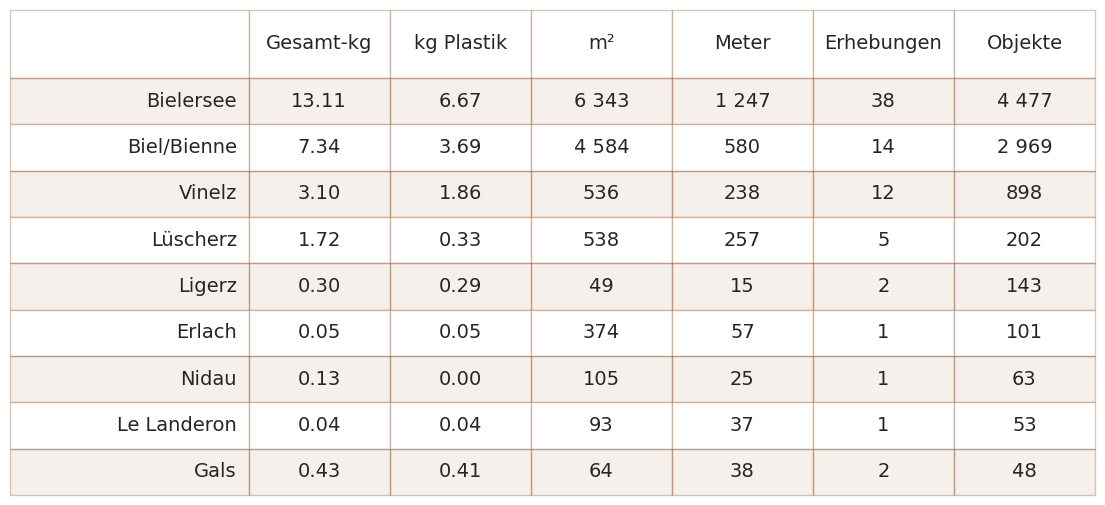

In [19]:
# make table
data = dims_table.reset_index()
colLabels = data.columns

fig, ax = plt.subplots(figsize=(len(colLabels)*2,len(data)*.7))

sut.hide_spines_ticks_grids(ax)
table_one = sut.make_a_table(ax, data.values, colLabels=colLabels, a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### Verteilung der Erhebungsergebnisse

In [20]:

fd_dindex = fdx.sample_totals

# Daily totals from all other locations
ots = dict(level_to_exclude=this_feature["level"], components_to_exclude=fd[this_feature["level"]].unique())
dts_date = sut.the_other_surveys(a_data, **ots)
dts_date = dts_date.groupby(["loc_date","date"], as_index=False)[unit_label].sum()
dts_date["date"] = pd.to_datetime(dts_date["date"]).dt.tz_localize('UTC')   

# scale the chart as needed to accomodate for extreme values
y_lim = 95
y_limit = np.percentile(dts_date[unit_label], y_lim)

# label for the chart that alerts to the scale
not_included = F"Werte grösser als {thousandsSeparator(int(round(y_limit,0)), language)} {p_unit_label} werden nicht gezeigt."

chart_notes = f"""
*__Links:__ {this_feature["name"]}, {dateToYearAndMonth(datetime.strptime(start_date, date_format), lang=date_lang)} bis {dateToYearAndMonth(datetime.strptime(end_date, date_format), lang=date_lang)}, n = {a_summary["loc_date"]}. {not_included} __Rechts:__ empirische Verteilungsfunktion der Erhebungsergebnisse {this_feature["name"]}.*
"""
md(chart_notes )


*__Links:__ Bielersee, März 2020 bis Mai 2021, n = 38. Werte grösser als 1 573 p/100 m werden nicht gezeigt. __Rechts:__ empirische Verteilungsfunktion der Erhebungsergebnisse Bielersee.*


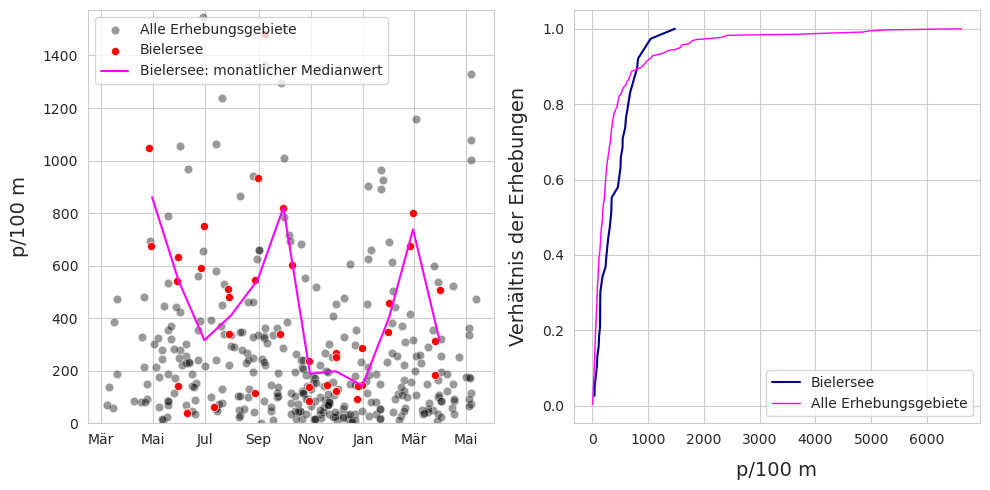

In [21]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html


months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")
days = mdates.DayLocator(interval=7)

# get the monthly or quarterly results for the feature
rsmp = fd_dindex.set_index("date")
resample_plot, rate = sut.quarterly_or_monthly_values(rsmp, this_feature["name"], vals=unit_label, quarterly=["ticino"])


fig, axs = plt.subplots(1,2, figsize=(10,5))

# the survey totals by day
ax = axs[0]

# feature surveys
sns.scatterplot(data=dts_date, x=dts_date["date"], y=unit_label, label=top, color="black", alpha=0.4,  ax=ax)
# all other surveys
sns.scatterplot(data=fd_dindex, x=fd_dindex["date"], y=unit_label, label=this_feature["name"], color="red", s=34, ec="white", ax=ax)
# monthly or quaterly plot
sns.lineplot(data=resample_plot, x=resample_plot.index, y=resample_plot, label=F"{this_feature['name']}: monatlicher Medianwert", color="magenta", ax=ax)

ax.set_ylim(0,y_limit )
ax.set_ylabel(p_unit_label, **ck.xlab_k14)

ax.set_xlabel("")
ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

# the cumlative distributions:
axtwo = axs[1]

# the feature of interest
feature_ecd = ECDF(fdx.sample_totals[unit_label].values)    
sns.lineplot(x=feature_ecd.x, y=feature_ecd.y, color="darkblue", ax=axtwo, label=this_feature["name"])

# the other features
other_features = ECDF(dts_date[unit_label].values)
sns.lineplot(x=other_features.x, y=other_features.y, color="magenta", label=top, linewidth=1, ax=axtwo)

axtwo.set_xlabel(p_unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

plt.tight_layout()
plt.show()

### Zusammengefasste Daten und Materialarten

In [22]:
# figure caption
summary_of_survey_totals = f"""
*__Links:__ Zusammenfassung der Daten aller Erhebungen am {this_feature["name"]}. __Rechts:__ Gefundene Materialarten am {this_feature["name"]} in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).*
"""
md(summary_of_survey_totals)


*__Links:__ Zusammenfassung der Daten aller Erhebungen am Bielersee. __Rechts:__ Gefundene Materialarten am Bielersee in Stückzahlen und als prozentuale Anteile (stückzahlbezogen).*


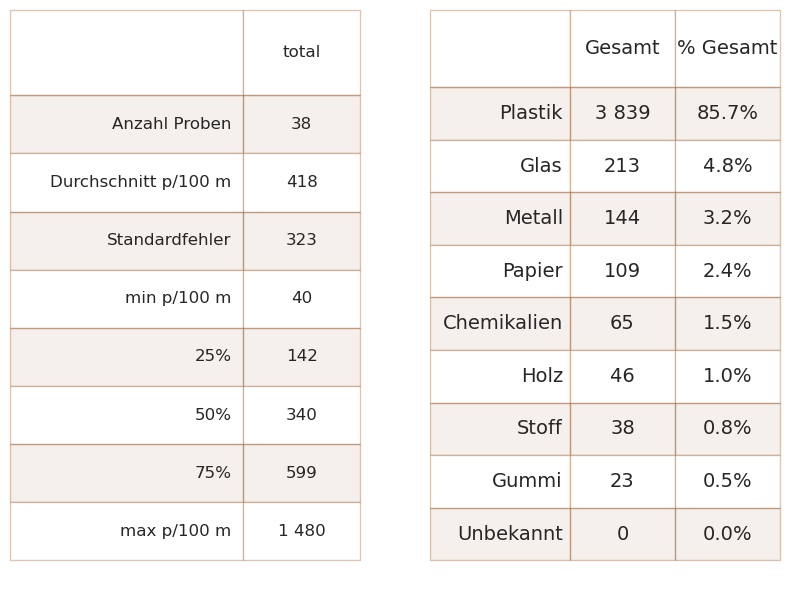

In [23]:
csx = fdx.sample_summary.copy()


combined_summary =[(x, thousandsSeparator(int(csx[x]), language)) for x in csx.index]


# the materials table
fd_mat_totals = fdx.material_summary.copy()
fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Gesamt", "% of total":"% Gesamt"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values
fd_mat_t = [(x[0], thousandsSeparator(int(x[1]), language), x[2]) for x in fd_mat_t]

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature["name"], "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")
table_two.set_fontsize(12)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

## Die am häufigsten gefundenen Objekte

Die am häufigsten gefundenen Objekte sind die zehn mengenmässig am meisten vorkommenden Objekte und/oder Objekte, die in mindestens 50 % aller Datenerhebungen identifiziert wurden (Häufigkeitsrate)

In [24]:
# get percent of total
m_common_percent_of_total = fdx.most_common["quantity"].sum()/fdx.code_summary["quantity"].sum()
rb_string = f"""
*__Unten__: Häufigste Objekte im {this_feature['name']}: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte {int(m_common_percent_of_total*100)}% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*
"""
md(rb_string)


*__Unten__: Häufigste Objekte im Bielersee: d. h. Objekte mit einer Häufigkeitsrate von mindestens 50 % und/oder Top Ten nach Anzahl. Zusammengenommen machen die häufigsten Objekte 73% aller gefundenen Objekte aus. Anmerkung: p/100 m = Medianwert der Erhebung.*


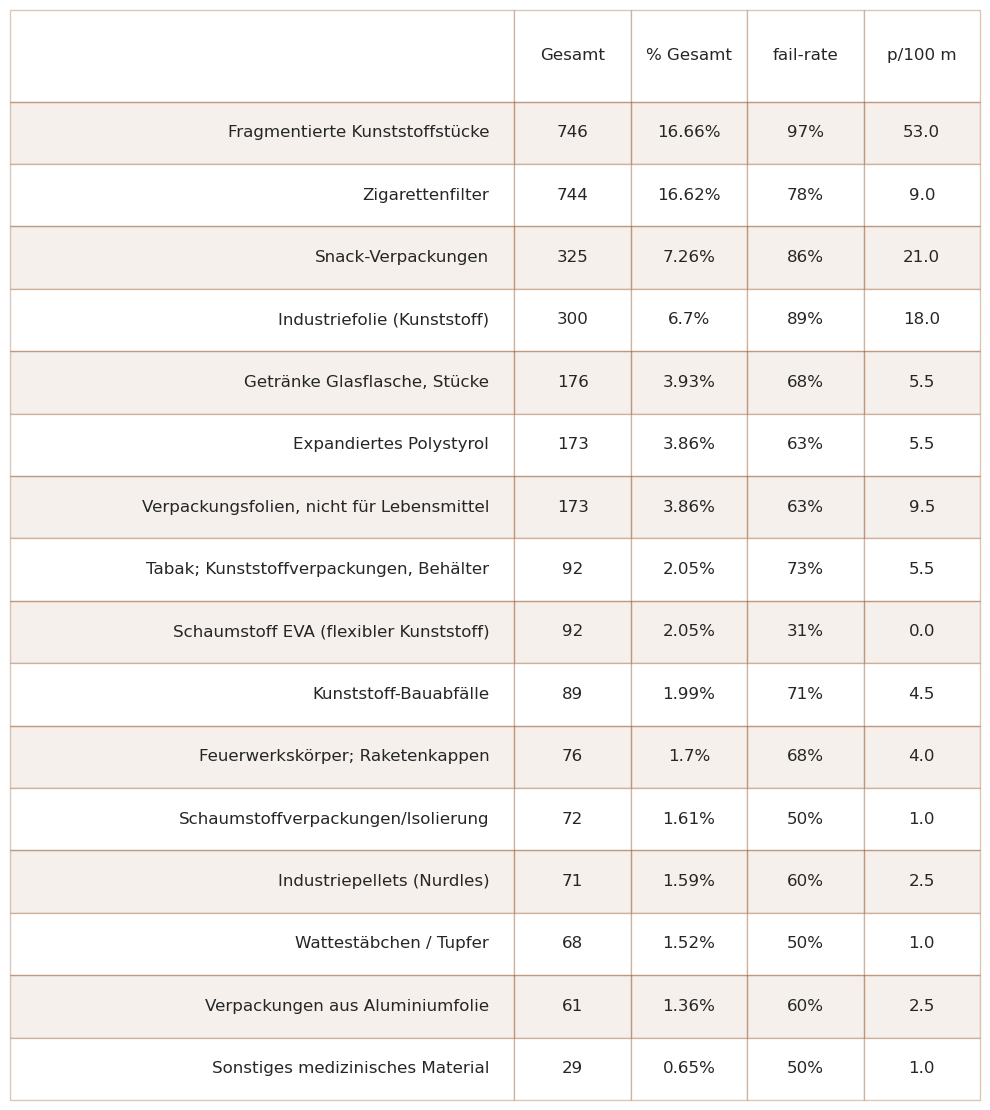

In [25]:
# format values for table
m_common = fdx.most_common.copy()
m_common["item"] = m_common.index.map(lambda x: fdx.dMap.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x:thousandsSeparator(x, language))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")
cols_to_use = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"fail-rate", unit_label:unit_label}
# cols_to_use = {"item":"Item","quantity":"Quantity", "% of total":"% of total", "fail rate":"Fail rate", unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")
table_four.set_fontsize(12)
plt.tight_layout()
plt.show()

### Die am häufigsten gefundenen Objekte nach Gemeinden

In [26]:
rb_string = F"""
*__Unten:__ Median (p/100 m) der häufigsten Objekte am {this_feature["name"]}.*
"""
md(rb_string)


*__Unten:__ Median (p/100 m) der häufigsten Objekte am Bielersee.*


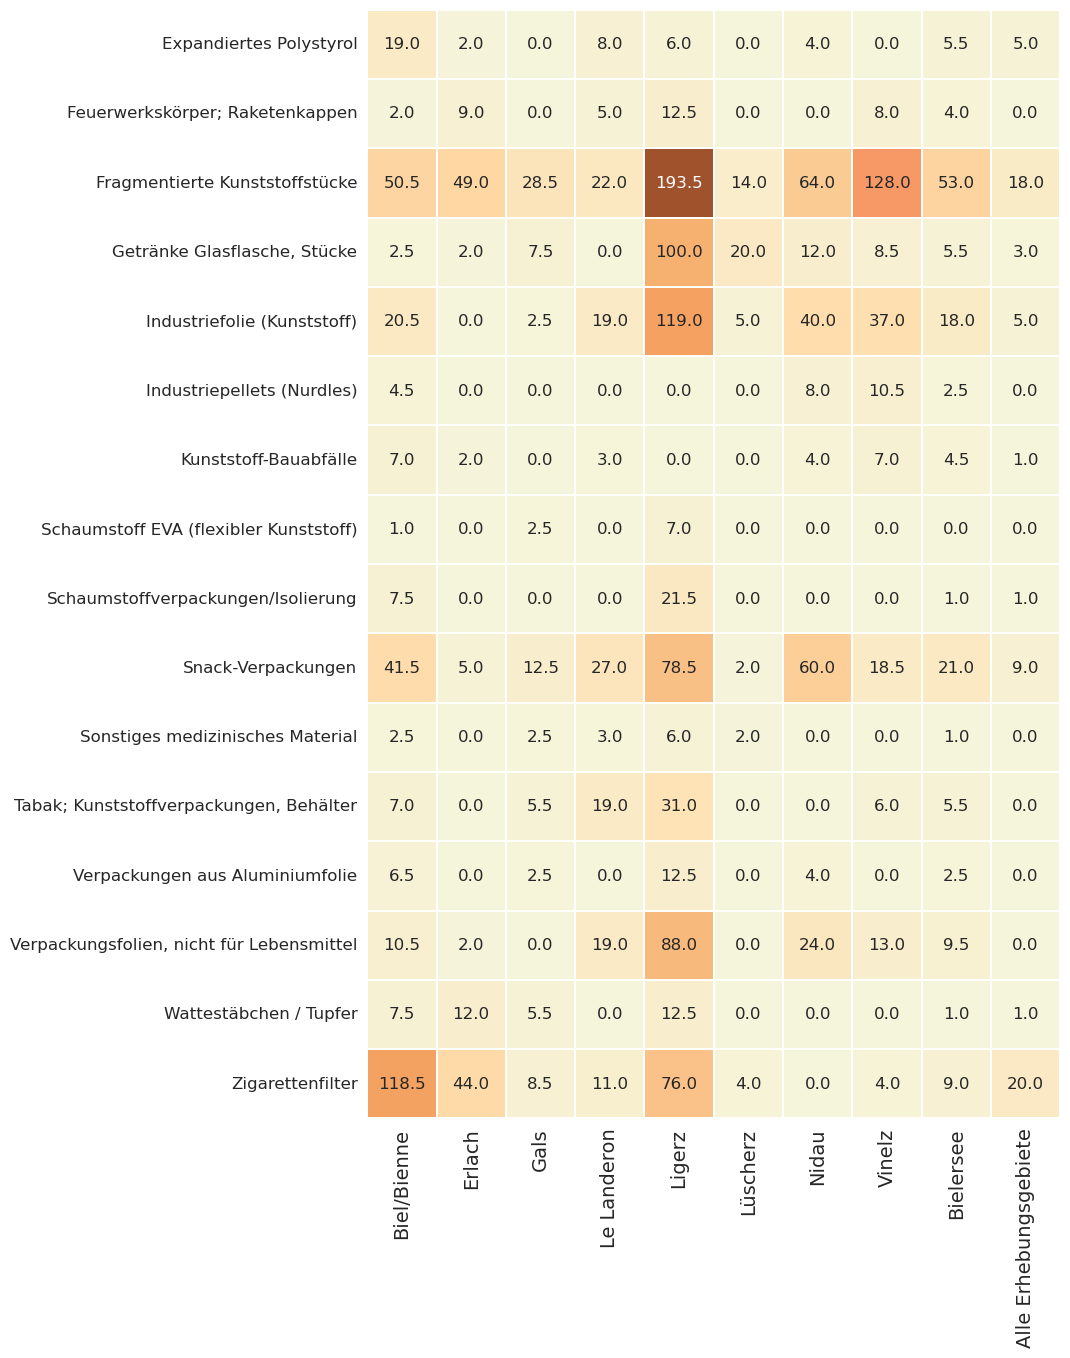

In [27]:
m_common_ft = fdx.componentMostCommonPcsM()

# pivot that
m_c_p = m_common_ft[["item", unit_label, "city"]].pivot(columns="city", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the survey area
c = sut.aggregate_to_group_name(fd[fd.code.isin(m_common.index)], column="code", name=this_feature["name"], val="med", unit_label=unit_label)

m_c_p[this_feature["name"]]= sut.change_series_index_labels(c, {x:fdx.dMap.loc[x] for x in c.index})

# the aggregated totals of all the data
c = sut.aggregate_to_group_name(a_data[(a_data.code.isin(m_common.index))], column="code", name=top, val="med", unit_label=unit_label)
m_c_p[top] = sut.change_series_index_labels(c, {x:fdx.dMap.loc[x] for x in c.index})

# chart that
fig, ax  = plt.subplots(figsize=(len(m_c_p.columns)*.9,len(m_c_p)*.9))
axone = ax

sns.heatmap(m_c_p, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")
axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="x")
axone.tick_params(labelsize=12, which="both", axis="y")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Die am häufigsten gefundenen Objekte im monatlichen Durchschnitt

In [28]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values
an_order

array(['G95', 'G177', 'G200', 'G30', 'G904', 'G940', 'G74', 'G89',
       'Gfoam', 'G67', 'G112', 'G941', 'G211', 'Gfrags', 'G25', 'G27'],
      dtype=object)

In [29]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*__Below:__ {this_feature["name"]}, monatliche Durchschnittsergebnisse p/100 m.*
"""
md(monthly_mc)


*__Below:__ Bielersee, monatliche Durchschnittsergebnisse p/100 m.*


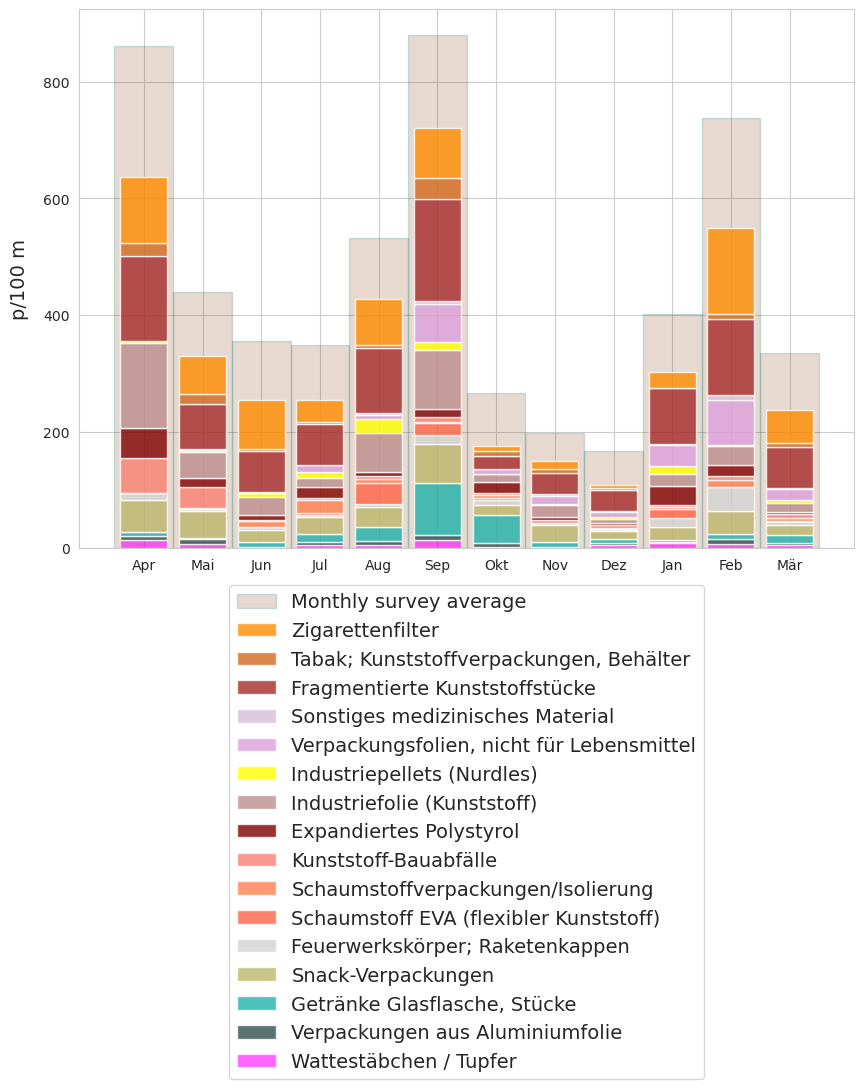

In [30]:
months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(10,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(["loc_date", "date"], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=table_row, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
#label the xticks by month
axisticks = ax.get_xticks()
labelsx = [sut.months_de[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [fdx.dMap.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(.5, -.05), loc="upper center",  ncol=1, fontsize=14)       
plt.show()

## Verwendungszweck der gefundenen Objekte

Der Verwendungszweck basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden einer der 260 vordefinierten Kategorien zugeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

* Abwasser: Objekte, die aus Kläranlagen freigesetzt werden, sprich Objekte, die wahrscheinlich über die Toilette entsorgt werden
* Mikroplastik (< 5 mm): fragmentierte Kunststoffe und Kunststoffharze aus der Vorproduktion
* Infrastruktur: Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Strassen und der Wasser-/Stromversorgung
* Essen und Trinken: alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
* Landwirtschaft: Materialien z. B. für Mulch und Reihenabdeckungen, Gewächshäuser, Bodenbegasung, Ballenverpackungen. Einschliesslich Hartkunststoffe für landwirtschaftliche Zäune, Blumentöpfe usw.
* Tabakwaren: hauptsächlich Zigarettenfilter, einschliesslich aller mit dem Rauchen verbundenen Materialien
* Freizeit und Erholung: Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw.
* Verpackungen ausser Lebensmittel und Tabak: Verpackungsmaterial, das nicht lebensmittel- oder tabakbezogen ist
* Plastikfragmente: Plastikteile unbestimmter Herkunft oder Verwendung
* Persönliche Gegenstände: Accessoires, Hygieneartikel und Kleidung

Im Anhang (Kapitel 3.6.3) befindet sich die vollständige Liste der identifizierten Objekte, einschliesslich Beschreibungen und Gruppenklassifizierung. Das Kapitel [16 Codegruppen](codegroups) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe.

In [31]:
cg_poft = F"""
__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden im Erhebungsgebiet {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.
"""
md(cg_poft)


__Unten:__ Verwendungszweck oder Beschreibung der identifizierten Objekte in % der Gesamtzahl nach Gemeinden im Erhebungsgebiet Bielersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.


city
Biel/Bienne    2969
Erlach          101
Gals             48
Le Landeron      53
Ligerz          143
Name: quantity, dtype: int64


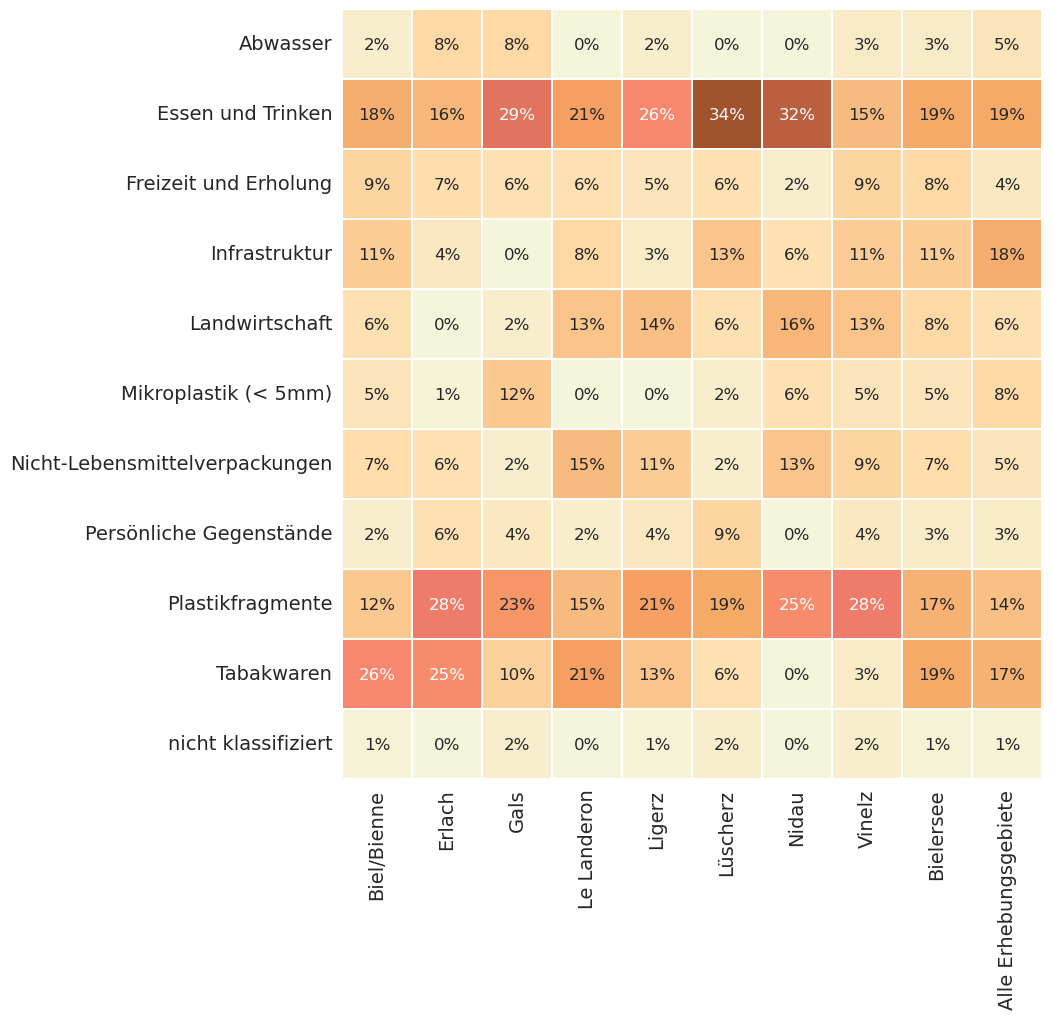

In [32]:
# get the percent of total for each group for each survey area
cg_t = fdx.componentCodeGroupResults()

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

# repeat for the survey area
data_table[this_feature['name'] ] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=this_feature['name'] , val="pt")

# repeat for all the data
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="pt")

data = data_table

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_ylabel("")
axone.set_xlabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [33]:
cg_medpcm = F"""
<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median p/100 m am {this_feature["name"]}. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*
"""
md(cg_medpcm)


<br></br>
*__Unten:__ Verwendungszweck der gefundenen Objekte Median p/100 m am Bielersee. Fragmentierte Objekte, die nicht eindeutig identifiziert werden können, werden weiterhin nach ihrer Grösse klassifiziert.*


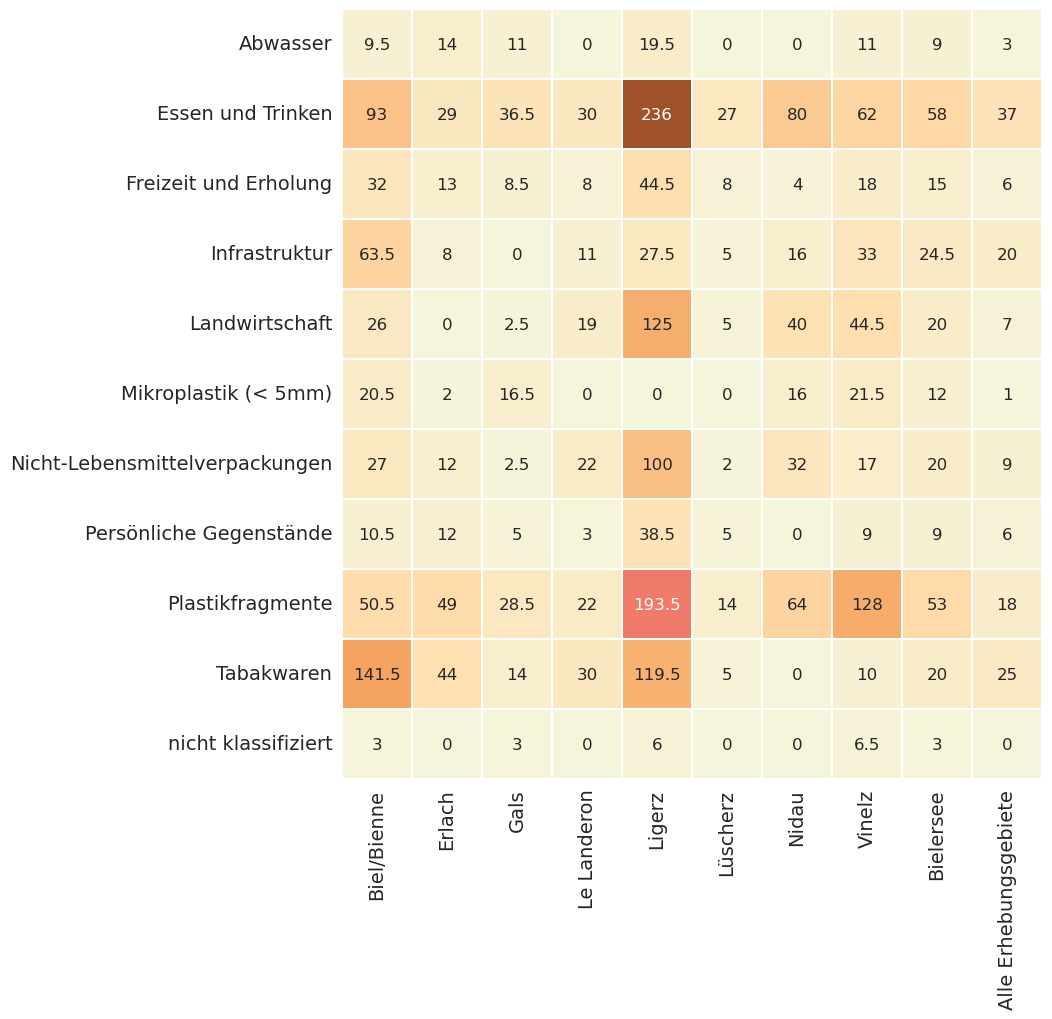

In [34]:
# median p/50m of all the water features
data_table = cg_t.pivot(columns="city", index="groupname", values=unit_label)

# the survey area columns
data_table[this_feature['name'] ] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=this_feature['name'] , val="med")

# column for all the surveys
data_table[top] = sut.aggregate_to_group_name(a_data, unit_label=unit_label, column="groupname", name=top, val="med")

# merge with data_table
data = data_table
# data.rename(columns={x:wname_wname.loc[x][0] for x in data.columns[:-2]}, inplace=True)
fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Anhang

### Schaumstoffe und Kunststoffe nach Grösse

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrag», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm. Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert.

In [35]:
frag_foams = F"""
*__Below:__ Fragmentierte und geschäumte Kunststoffe nach Grösse am {this_feature["name"]},  Median p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.*
"""
md(frag_foams)


*__Below:__ Fragmentierte und geschäumte Kunststoffe nach Grösse am Bielersee,  Median p/100 m, Anzahl der gefundenen Objekte und Prozent der Gesamtmenge.*


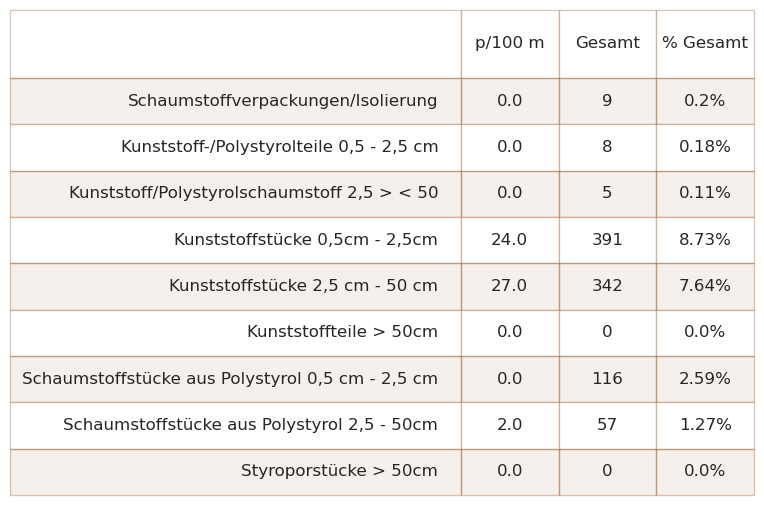

In [36]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams

agg_pcs_median = {unit_label:"median", "quantity":"sum"}
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
some_foams = ["G81", "G82", "G83", "G74"]
before_agg.rename(columns={"p/100m":unit_label}, inplace=True)

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(a_summary["locations_of_interest"]))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg(agg_pcs_median)

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: fdx.dMap.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]
data.rename(columns={"quantity":"Gesamt", "% of total":"% Gesamt"}, inplace=True)

fig, axs = plt.subplots(figsize=(len(data.columns)*2.4,len(data)*.7))

sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs,data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], a_color=table_row)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")
table_seven.set_fontsize(12)

plt.show()
plt.tight_layout()
plt.close()

### Die Erhebungsorte

In [37]:
# display the survey locations
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[a_summary["locations_of_interest"]][disp_columns]
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns={"city":"stat", "slug":"standort"}, inplace=True)
disp_beaches.set_index("standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,stat
standort,,,
mullermatte,47.133339,7.227907,Biel/Bienne
bielersee_vinelz_fankhausers,47.038398,7.108311,Vinelz
erlach-camping-strand,47.047159,7.097854,Erlach
luscherz-plage,47.047955,7.151242,Lüscherz
strandboden-biel,47.132510,7.233142,Biel/Bienne
nidau-strand,47.127196,7.232613,Nidau
camp-des-peches,47.052812,7.074053,Le Landeron
ligerz-strand,47.083979,7.135894,Ligerz
gals-reserve,47.046272,7.085007,Gals


### Inventar der Objekte

In [38]:
pd.set_option("display.max_rows", None)
complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]
complete_inventory.rename(columns={"item":"Objekte", "groupname":"Gruppenname", "quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"fail rate" }, inplace=True)


complete_inventory.sort_values(by="Gesamt", ascending=False)

NameError: name 'code_totals' is not defined